# Scraping and analysing customer reviews to uncover findings for British Airways


---
The analysis involves web scraping, sentiment analysis and topic modeling.



In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt


import nltk
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
from gensim import corpora, models


## 1. Prepare


In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


## 2. Process

In [3]:
orig = pd.DataFrame()
orig["reviews"] = reviews

In [4]:
reviews = orig.copy()
reviews

,reviews
0,✅ Trip Verified | A simple story with an unfor...
1,✅ Trip Verified | Flight was delayed due to t...
2,Not Verified | Fast and friendly check in (to...
3,✅ Trip Verified | I don't understand why Brit...
4,Not Verified | I'm sure that BA have graduall...
...,...
995,✅ Trip Verified | British Airways is my favor...
996,✅ Trip Verified | Rome to Newark via London. ...
997,✅ Trip Verified | London Heathrow to New York...
998,Not Verified | London Heathrow to Dubai. This...


In [5]:
reviews.nunique()

reviews    1000
dtype: int64

There are no NaN values

In [6]:

reviews.isna().sum()

reviews    0
dtype: int64

__splitting the review into trip status and the actual review__<br>

In [7]:
# remove the ✅ and ❎ symbols and remove the whitespaces before and after them to get two unique trip status 
reviews['reviews'] = reviews['reviews'].str.replace('✅ ', '').str.replace('❎ ', '').str.replace('✅', '').str.replace('❎', '')

reviews[['status', 'review']] = reviews["reviews"].str.split(' \|', n=1, expand=True)

# remove the reviews columns in place 
reviews.drop('reviews', axis=1, inplace=True)
reviews

,status,review
0,Trip Verified,A simple story with an unfortunate outcome th...
1,Trip Verified,Flight was delayed due to the inbound flight...
2,Not Verified,Fast and friendly check in (total contrast t...
3,Trip Verified,I don't understand why British Airways is cl...
4,Not Verified,I'm sure that BA have gradually made their e...
...,...,...
995,Trip Verified,British Airways is my favorite airline. Boei...
996,Trip Verified,Rome to Newark via London. The first sector ...
997,Trip Verified,London Heathrow to New York JFK. The First W...
998,Not Verified,London Heathrow to Dubai. This was the first...


__Clean and preprocess the review column by removing punctations, convert all words to lowercase, etc.__

In [8]:


# Download NLTK resources 
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Text preprocessing function
def preprocess_review(review):
    
    # Convert to lowercase
    review = review.lower()

    # Remove punctuation
    review = review.translate(str.maketrans('', '', string.punctuation))

    # Tokenize the text
    review = word_tokenize(review)

    # Remove stopwords like this, is, a, an, etc. as it has not effect on the sentance analysis 
    # we want to reduce the dims and focus on the meanning of the individuals words and such stopwords has no meaning in the analysis 
    stop_words = set(stopwords.words('english'))
    words = [word for word in review if word not in stop_words]

    # Lemmatize the words
    #Reduce the words variantion for instance playing => play
    # without limitizing the words such words  (playing and play) will be treated as diff words 
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # the output of tokenize  is a list so we wanna join this list back to form a sentence 
    # Join the words back to form sentences
    processed_review = ' '.join(words)
    return processed_review

# Apply preprocessing to the 'review_text' column
reviews['processed_review'] = reviews['review'].apply(preprocess_review)
reviews

[nltk_data] Downloading package punkt to /Users/admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/admin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,status,review,processed_review
0,Trip Verified,A simple story with an unfortunate outcome th...,simple story unfortunate outcome really could ...
1,Trip Verified,Flight was delayed due to the inbound flight...,flight delayed due inbound flight arriving lat...
2,Not Verified,Fast and friendly check in (total contrast t...,fast friendly check total contrast gatwick con...
3,Trip Verified,I don't understand why British Airways is cl...,dont understand british airway classified 4 st...
4,Not Verified,I'm sure that BA have gradually made their e...,im sure ba gradually made economy experience b...
...,...,...,...
995,Trip Verified,British Airways is my favorite airline. Boei...,british airway favorite airline boeing 777 21 ...
996,Trip Verified,Rome to Newark via London. The first sector ...,rome newark via london first sector a319 fligh...
997,Trip Verified,London Heathrow to New York JFK. The First W...,london heathrow new york jfk first wing termin...
998,Not Verified,London Heathrow to Dubai. This was the first...,london heathrow dubai first time flown first c...


In [9]:
reviews['status'].unique()

array(['Trip Verified', 'Not Verified'], dtype=object)

__Perform sentiment analysis and sitting a threshold__  
```'positive' if score > 0.01 else ('negative' if score < -0.01 else 'neutral')```

In [10]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Calculate sentiment scores for each review
reviews['sentiment_score'] = reviews['processed_review'].apply(lambda text: sia.polarity_scores(text)['compound'])

# Classify reviews as positive, negative, or neutral based on the sentiment score
reviews['sentiment_category'] = reviews['sentiment_score'].apply(lambda score: 'positive' if score > 0.01 else ('negative' if score < -0.01 else 'neutral'))

# Display the first 16 rows of the DataFrame
reviews.head(16)


,status,review,processed_review,sentiment_score,sentiment_category
0,Trip Verified,A simple story with an unfortunate outcome th...,simple story unfortunate outcome really could ...,0.8107,positive
1,Trip Verified,Flight was delayed due to the inbound flight...,flight delayed due inbound flight arriving lat...,-0.2732,negative
2,Not Verified,Fast and friendly check in (total contrast t...,fast friendly check total contrast gatwick con...,0.9790,positive
3,Trip Verified,I don't understand why British Airways is cl...,dont understand british airway classified 4 st...,0.9168,positive
4,Not Verified,I'm sure that BA have gradually made their e...,im sure ba gradually made economy experience b...,0.8008,positive
5,Trip Verified,Customer Service does not exist. One world e...,customer service exist one world emerald frequ...,0.5932,positive
6,Trip Verified,"Another really great pair of flights, on time...",another really great pair flight time problem ...,0.9829,positive
7,Not Verified,Our A380 developed a fault taxiing to the ru...,a380 developed fault taxiing runway returned g...,-0.5710,negative
8,Not Verified,Horrible airline. Does not care about their c...,horrible airline care customer used decent sin...,-0.0772,negative
9,Trip Verified,My family and I have flown mostly on British...,family flown mostly british airway last 30 yea...,0.9421,positive


__Type casting to ensure that our data is valid and consistant__

In [11]:
reviews['status'] = reviews['status'].astype('string')
reviews['review'] = reviews['review'].astype('string')
reviews['processed_review'] = reviews['processed_review'].astype('string')
reviews['sentiment_category'] = reviews['sentiment_category'].astype('string')

## 3. Analyze

In [12]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   status              1000 non-null   string 
 1   review              1000 non-null   string 
 2   processed_review    1000 non-null   string 
 3   sentiment_score     1000 non-null   float64
 4   sentiment_category  1000 non-null   string 
dtypes: float64(1), string(4)
memory usage: 39.2 KB


We see that the overall sentiment_category positive and negative are almost equal which alligns with the overall  Customer rating 5/10 in the airlinequality reviews.


In [13]:
reviews['status'].describe()

count              1000
unique                2
top       Trip Verified
freq                798
Name: status, dtype: object

In [14]:
reviews['sentiment_category'].describe()

count         1000
unique           3
top       positive
freq           586
Name: sentiment_category, dtype: object

In [15]:
reviews['sentiment_category'].value_counts()

positive    586
negative    406
neutral       8
Name: sentiment_category, dtype: Int64

In [16]:
reviews['sentiment_category'].value_counts(normalize=True)

positive    0.586
negative    0.406
neutral     0.008
Name: sentiment_category, dtype: Float64

In [17]:
# Sort the DataFrame by sentiment score 
reviews_sorted = reviews.sort_values(by='sentiment_score', ascending=True)

# top negative reviews ( will include 100 of the top negative reviews )
top_negative_reviews = reviews_sorted[reviews_sorted['sentiment_category'] == 'negative'].head(100)

print(top_negative_reviews[['review', 'sentiment_score']])


                                                review  sentiment_score
694    Hong Kong to Copenhagen via London. The whol...          -0.9935
770    London to Nashville. The worst airline Trans...          -0.9925
202    We boarded our flight at Edinburgh to London...          -0.9876
59     Words fail to describe this last awful fligh...          -0.9858
156   Probably the worst business class experience ...          -0.9845
..                                                 ...              ...
965    Abu Dhabi to London. Although a BA flight, t...          -0.8683
918    Athens to Los Angeles via London. Worst flig...          -0.8667
625    London Gatwick to Salzburg with British Airw...          -0.8658
171    Missing baggage customer service was the wor...          -0.8625
897    Antigua to Gatwick. Apparently it is necessa...          -0.8592

[100 rows x 2 columns]


__(TOPIC MODELING) Extract the top words associated with the negative reviews using LDA model__

__The top words represent issues related to the service, food, staff and customer support and service.__


In [18]:

tokenized_reviews = [word_tokenize(review) for review in reviews['processed_review']]

dictionary = corpora.Dictionary(tokenized_reviews)

bow_corpus = [dictionary.doc2bow(tokens) for tokens in tokenized_reviews]

lda_model = models.LdaModel(bow_corpus, num_topics=5, id2word=dictionary, passes=10)

# top words for each topic
topics = lda_model.print_topics(num_words=5)

for topic in topics:
    print(topic)

(0, '0.029*"flight" + 0.015*"ba" + 0.012*"’" + 0.010*"customer" + 0.009*"hour"')
(1, '0.024*"seat" + 0.018*"flight" + 0.014*"class" + 0.013*"ba" + 0.013*"business"')
(2, '0.028*"flight" + 0.013*"ba" + 0.009*"hour" + 0.009*"time" + 0.009*"london"')
(3, '0.023*"flight" + 0.012*"good" + 0.012*"service" + 0.011*"seat" + 0.011*"ba"')
(4, '0.024*"flight" + 0.021*"ba" + 0.010*"london" + 0.010*"seat" + 0.006*"airline"')


## 4. Share

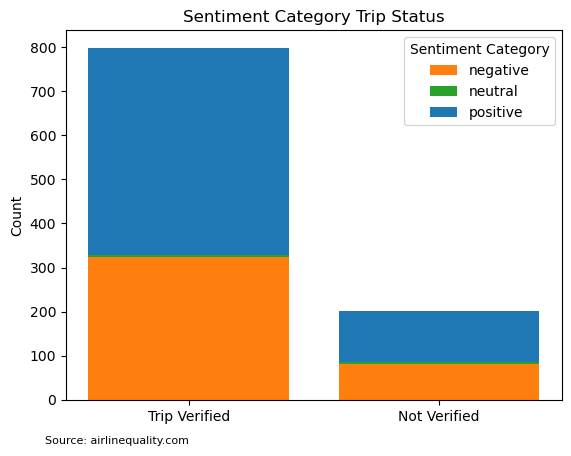

In [19]:
sentiment_status_counts = reviews.groupby(['status', 'sentiment_category']).size().unstack()

colors = ['#ff7f0e', '#2ca02c', '#1f77b4']

# display "Trip Verified"  first
sentiment_status_counts = sentiment_status_counts.loc[['Trip Verified', 'Not Verified']]

bottom = None
for i, sentiment_category in enumerate(sentiment_status_counts.columns):
    plt.bar(sentiment_status_counts.index, sentiment_status_counts[sentiment_category], color=colors[i], label=sentiment_category, bottom=bottom)
    if bottom is None:
        bottom = sentiment_status_counts[sentiment_category].values
    else:
        bottom += sentiment_status_counts[sentiment_category].values

# Set labels and title
plt.ylabel('Count')
plt.title('Sentiment Category Trip Status')
plt.legend(title='Sentiment Category')

data_source = 'Source: airlinequality.com'
plt.text(0, -100, data_source, ha='right', fontsize=8)

# Show the plot
plt.show()


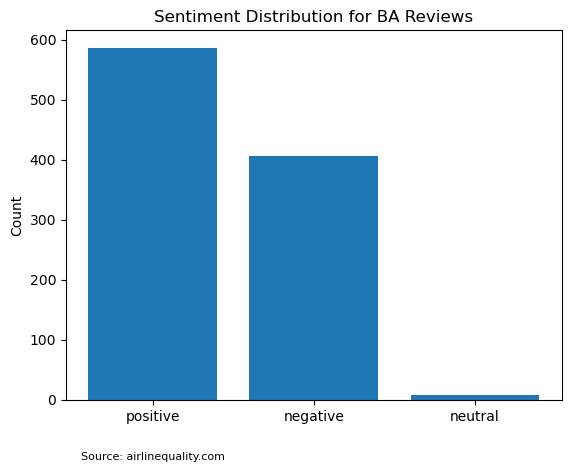

In [20]:


sentiment_counts = reviews['sentiment_category'].value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.ylabel('Count')
plt.title('Sentiment Distribution for BA Reviews')

data_source = 'Source: airlinequality.com'
plt.text(0, -100, data_source, ha='center', fontsize=8)

plt.show()



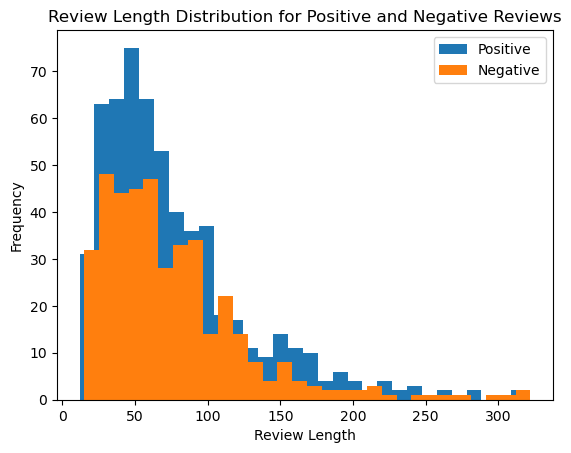

In [21]:
# Filter positive and negative reviews
positive_reviews = reviews[reviews['sentiment_category'] == 'positive']
negative_reviews = reviews[reviews['sentiment_category'] == 'negative']

# Calculate the length of each review text
positive_review_lengths = positive_reviews['processed_review'].apply(lambda x: len(x.split()))
negative_review_lengths = negative_reviews['processed_review'].apply(lambda x: len(x.split()))

# Create histograms for review length distribution
plt.hist(positive_review_lengths, bins=30, label='Positive')
plt.hist(negative_review_lengths, bins=30, label='Negative')

# Set labels and title
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Review Length Distribution for Positive and Negative Reviews')
plt.legend()


# Show the plot
plt.show()


## 5. Act

__Recommendations:__

Based on the words collected from the LDA model and me exploring the df reviews.
1. Focus on Improving Customer Service:
 - Address customer service issues to improve the overall customer experience by hiring more representatives to provide a faster response rate and solve the issues on time
 - Find the gaps in the team and provide training to handle complaints and requests more effectively.
2. Identify reasons for flight delays and implement strategies to minimize them.
3. Improve the seats' comfort:
 - Review seating arrangements and comfort satisfaction.
 - Offer options for seat upgrades.


In [22]:
reviews.to_csv("./BA_reviews.csv")